In [28]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
import os

import brighteyes_ism.dataio.mcs as mcs
import brighteyes_ism.analysis.Graph_lib as gr
import brighteyes_ism.simulation.PSF_sim as sim

from s2ism import s2ism as s2
import s2ism.psf_estimator as est

# Data download

Experimental dataset can be downloaded from [https://doi.org/10.5281/zenodo.11284051](https://doi.org/10.5281/zenodo.11284051).

Here, we download and decompress the data into the Downloas folder.

In [2]:
import requests
from tqdm import tqdm, trange
from pathlib import Path
import os
import zipfile

def download(url, fname):
    resp = requests.get(url, stream=True)
    total = int(resp.headers.get('content-length', 0))
    with open(fname, 'wb') as file, tqdm(
            desc=fname,
            total=total,
            unit='iB',
            unit_scale=True,
            unit_divisor=1024,
    ) as bar:
        for data in resp.iter_content(chunk_size=1024):
            size = file.write(data)
            bar.update(size)
            
def extract(filename):
    dir_name = filename[:-4]
    os.mkdir(dir_name)
    with zipfile.ZipFile(filename, 'r') as zf:
        for member in tqdm(zf.infolist(), desc='Extracting '):
            try:
                zf.extract(member, dir_name)
            except zipfile.error as e:
                pass

In [3]:
downloads_path = str(Path.home() / 'Downloads')

url_data = 'https://zenodo.org/records/11284051/files/h5_files_s2ism.zip'
name_data = 'h5_files_s2ism.zip'

filename = os.path.join(downloads_path, name_data)

In [4]:
if not os.path.isfile(filename):
    print('Downloading data:' + filename + '\n')
    download(url_data, filename)
else:
    print('File already downloaded.')

File already downloaded.


In [5]:
dir_name = filename[:-4]

if not os.path.exists(dir_name):
    print('Extracting compressed data:\n')
    extract(filename)

# Data loading

In [19]:
file = 'Mithocondria_timelapse_data-09-11-2023-13-29-23.h5'

fullpath = os.path.join(dir_name, file)

data, meta = mcs.load(fullpath)

We print the metadata of the acquisition. The frames are saved into the repetition dimension.

In [25]:
meta.Print()

version       0.0.1
comment       
rangex        45.0
rangey        45.0
rangez        0.0
nbin          5
dt            4.0
nx            1125
ny            1125
nz            1
nrep          40
calib_x       17.303
calib_y       17.409
calib_z       4.75


In [20]:
print(data.shape)

(40, 1, 1125, 1125, 5, 25)


Squeezing the unnecessary dimensions and summing over the temporal bins to obtain a good SNR, nedded to launch the analysis: 

In [21]:
dset = np.squeeze(data)
del data

In [22]:
dset = dset.sum(axis = -2)

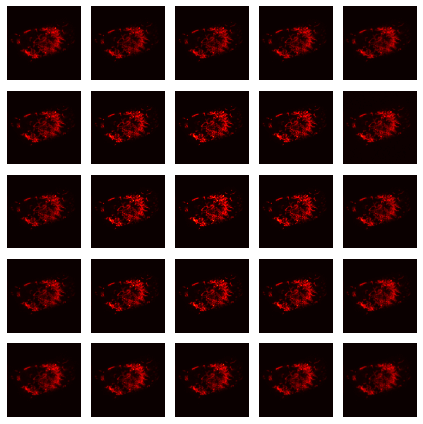

In [23]:
fig = gr.ShowDataset(dset[0])

Exctracting some dimensions from the raw dataset needed for the upcoming analysis:

In [26]:
sz = dset.shape
N = int( np.sqrt(sz[-1]) )

Simulating the complete PSFs extracting some fundamental characteristics of the imaging system from the raw dataset (for a deeper description of this process, check the 'Reconstruction_step_by_step_exp.ipynb' file notebook attached in the GitHub part of the ope-source code). In such a way we maximize the physical reliability of the simulation, obtaining PSFs as close as possible to the experimental ones (effectively describing the custom ISM setup used to acquire this particular dataset):

In [11]:
exPar = sim.simSettings()
exPar.wl = 561
exPar.mask_sampl = 101

emPar = exPar.copy()
emPar.wl = 590

Nx = meta.nx
Ny = meta.ny

grid = sim.GridParameters()
grid.pxsizex = meta.dx*1e3
grid.Nz = 2

psf_fin, det_psf, exc_psf = est.psf_estimator_from_data(dset, exPar, emPar, grid, z_out_of_focus='300')   
#out-of-focus position for the reconstruction is a-priori posed, and based on quantitative analysis deeply described in the paper itself.


Calculating the PSFs stack from z = -300.0 nm to z = 0.0 nm:


100%|██████████| 2/2 [13:20<00:00, 400.47s/it]


In [12]:
spad_size = grid.spad_size() / emPar.airy_unit
print(f'SPAD array size = {spad_size:.1f} AU')

SPAD array size = 1.5 AU


Qualitative check of the simulated PSFs:

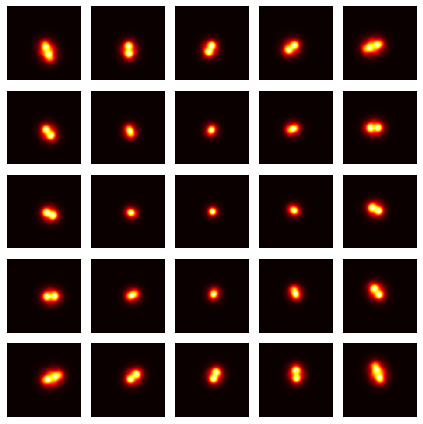

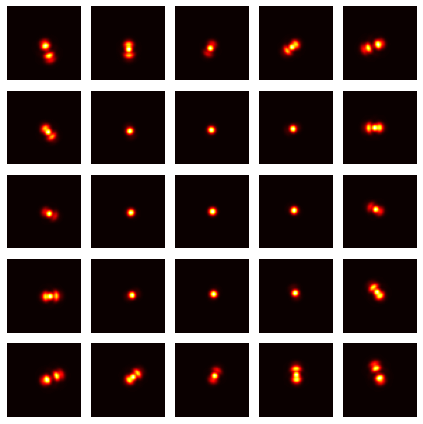

In [15]:
fig_1 = gr.ShowDataset(psf_fin[0])
fig_2 = gr.ShowDataset(psf_fin[1])

In [29]:
s2_focal_frames = np.empty( (meta.nrep, meta.nx, meta.ny) )

for f in trange(meta.nrep):
    s2ism_result = s2.max_likelihood_reconstruction(dset[f], psf_fin, stop = 'fixed', max_iter = 10, rep_to_save ='last')
    
    s2_images = s2ism_result[0]
    
    s2_focal_frames[f] = s2_images[1]

Progress: 11it [00:06,  1.76it/s]                        
Progress: 11it [00:06,  1.78it/s]                        
Progress: 11it [00:06,  1.78it/s]                        
Progress: 11it [00:06,  1.78it/s]                        
Progress: 11it [00:06,  1.77it/s]                        
Progress: 11it [00:06,  1.77it/s]                        
Progress: 11it [00:06,  1.74it/s]                        
Progress: 11it [00:06,  1.77it/s]                        
Progress: 11it [00:06,  1.74it/s]                        
Progress: 11it [00:06,  1.73it/s]                        
Progress: 11it [00:06,  1.75it/s]                        
Progress: 11it [00:06,  1.72it/s]                        
Progress: 11it [00:06,  1.69it/s]                        
Progress: 11it [00:06,  1.74it/s]                        
Progress: 11it [00:06,  1.74it/s]                        
Progress: 11it [00:06,  1.74it/s]                        
Progress: 11it [00:06,  1.78it/s]                        
Progress: 11it

Qualitative check of the s2ism in-focus reconstruction:

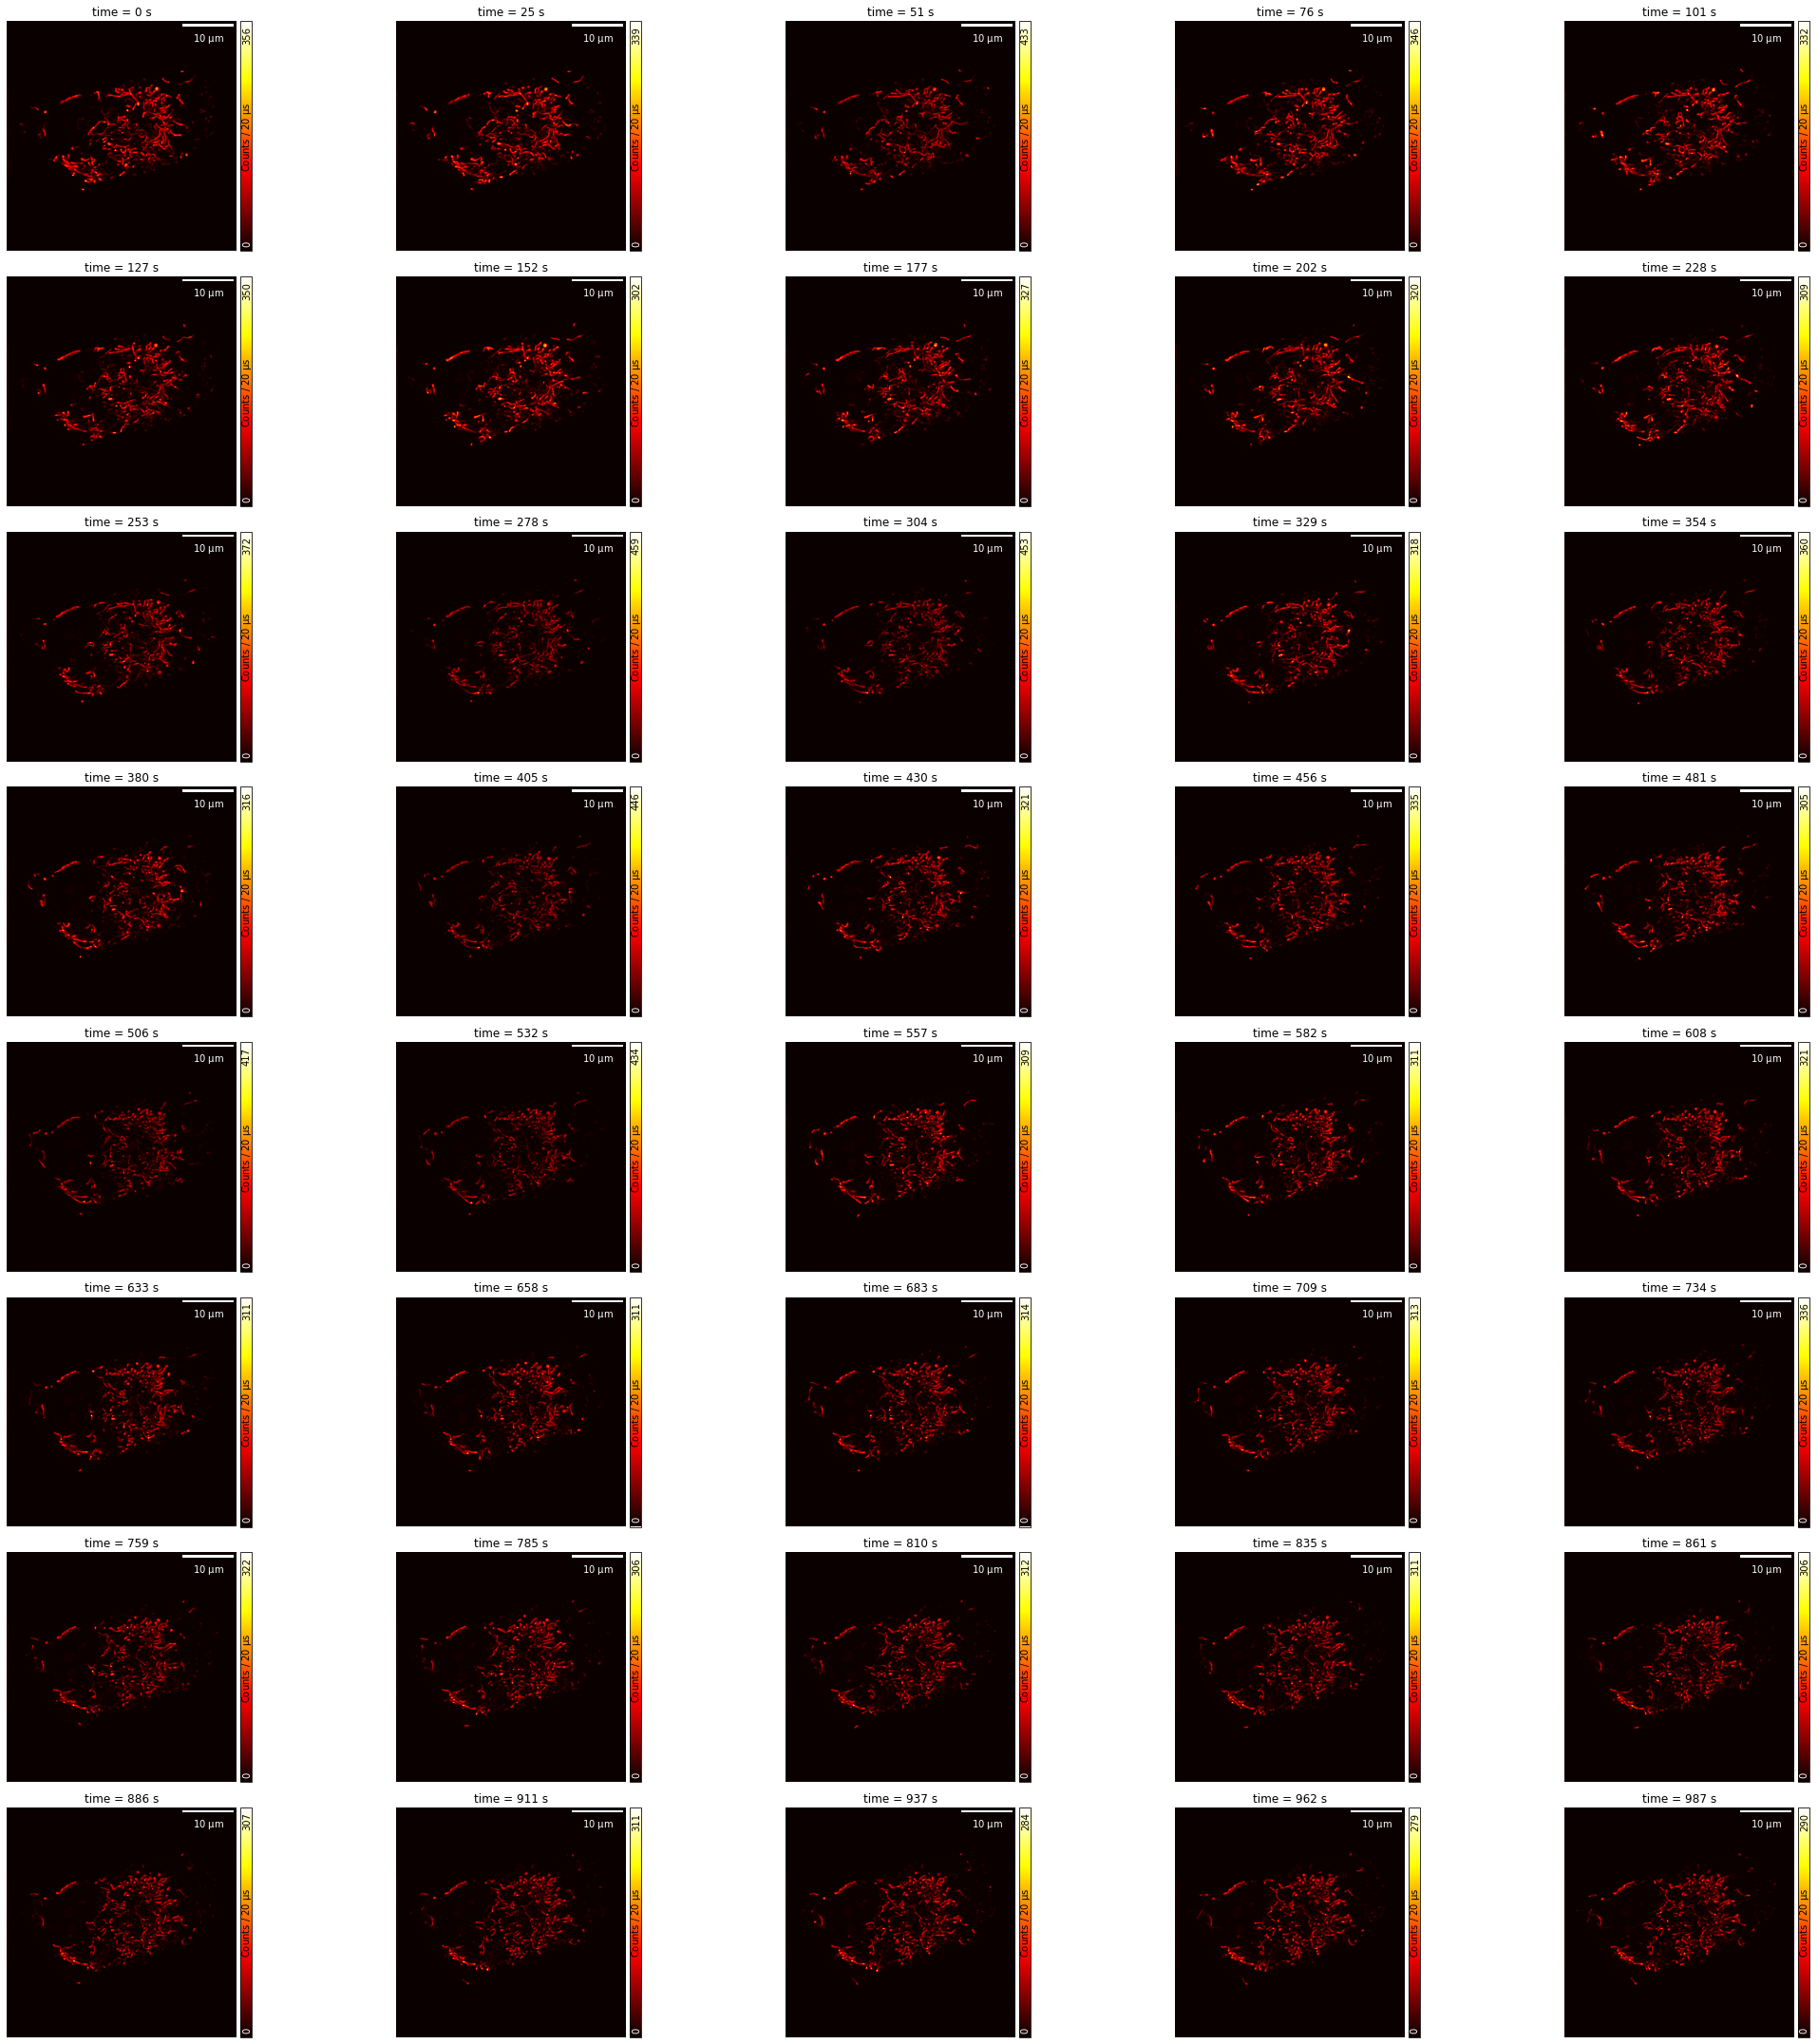

In [43]:
fig, ax = plt.subplots(8, 5, figsize = (30, 30))

for f in range(meta.nrep):
    idx = np.unravel_index(f, (8,5))
    gr.ShowImg(s2_focal_frames[f], meta.dx, meta.pxdwelltime, fig = fig, ax = ax[idx])
    ax[idx].set_title(f'time = {f*meta.frametime:.0f} s')
    
fig.tight_layout()